In [1]:
from time import time

import matplotlib.pyplot as plt

import numpy as np
from numpy.polynomial.chebyshev import chebpts1, chebvander

import sys,os
sys.path.append(os.getcwd())

import jax.numpy as jnp
from jax.scipy.linalg import expm as jexpm
from jax import vmap, jacfwd, jit
from jax.lax import cond, scan, associative_scan
from jax.config import config
config.update("jax_enable_x64", True)

from qiskit_ode import dispatch, solve_lmde
from qiskit_ode.dispatch import Array
from qiskit.quantum_info import Operator
from qiskit_ode.models import HamiltonianModel, Frame
from qiskit_ode.signals import Signal
from qiskit_ode_internal.perturbation import solve_lmde_perturbation

dispatch.set_default_backend('jax')

# 1. Define system parameters and operators

System parameters

In [2]:
w_c = 2 * np.pi * 5.1
w_t = 2 * np.pi * 5.
alpha_c = 2 * np.pi * (-0.33)
alpha_t = 2 * np.pi * (-0.33)
J = 2 * np.pi * 0.002
# drive strength
r = 2 * np.pi * 0.05

dim = 4

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = a.transpose()
N = np.diag(np.arange(dim))
ident = np.eye(dim)
ident2 = np.eye(dim**2)

# operators on the control qubit (first tensor factor)
a0 = np.kron(a, ident)
adag0 = np.kron(adag, ident)
N0 = np.kron(N, ident)

# operators on the target qubit (first tensor factor)
a1 = np.kron(ident, a)
adag1 = np.kron(ident, adag)
N1 = np.kron(ident, N)

Hamiltonian operators.

In [3]:
H0 = (w_c * N0 + 0.5 * alpha_c * N0 @ (N0 - ident2)
      + w_t * N1 + 0.5 * alpha_t * N1 @ (N1 - ident2)
      + J * (a0 @ adag1 + adag0 @ a1))
Hdc = r*(a0 + adag0)
Hdt = r*(a1 + adag1)

Pulse envelope to simulate.

In [4]:
def gauss(t, sig):
    t = Array(t).data
    return jnp.exp(- (t**2) / (2 *(sig **2)))

# this is getting a bit wild with the array wrapping but
# I've messed around with too many things
def pulse(sig, taur, tau, t):
    sig = Array(sig).data
    taur = Array(taur).data
    tau = Array(tau).data
    t = Array(t).data
    b = gauss(taur, sig)
    return cond(t < taur,
                lambda s: (gauss(t - taur, sig) - b) / (1 - b),
                lambda s: cond(t < tau-taur,
                               lambda r: 1.,
                               lambda r: (gauss(t - (tau - taur), sig) - b) / (1-b),
                               0.),
                0.)

## 1.1 Establish dressed energies

In [5]:
def basis_vec(ind, dimension):
    vec = np.zeros(dimension, dtype=complex)
    vec[ind] = 1.
    return vec

def two_q_basis_vec(inda, indb, dimension):
    vec_a = basis_vec(inda, dimension)
    vec_b = basis_vec(indb, dimension)
    return np.kron(vec_a, vec_b)

def get_dressed_state_index(inda, indb, dimension, evectors):
    b_vec = two_q_basis_vec(inda, indb, dimension)
    overlaps = np.abs(evectors @ b_vec)
    return overlaps.argmax()

def get_dressed_state_and_energy(inda, indb, dimension, evecs):
    ind = get_dressed_state_index(inda, indb, dimension, evecs)
    return evals[ind], evecs[ind]

Establish dressed energies and basis vectors

In [6]:
evals, B = jnp.linalg.eigh(H0)
Badj = B.conj().transpose()

E00, dressed00 = get_dressed_state_and_energy(0, 0, dim, B)
E01, dressed01 = get_dressed_state_and_energy(0, 1, dim, B)
E10, dressed10 = get_dressed_state_and_energy(1, 0, dim, B)
E11, dressed11 = get_dressed_state_and_energy(1, 1, dim, B)

In [7]:
w_d = E01
v_d = w_d / (2 * jnp.pi)
w_d - w_t

DeviceArray(-0.00025123, dtype=float64)

In [8]:
H0_B = Badj @ H0 @ B
Hdc_B = Badj @ Hdc @ B

def full_ham(t):
    return H0_B + pulse_func(t) * jnp.cos(w_d * t) * Hdc_B

# 2. Full simulation of the system

Set parameters of simulation (length of pulse, number of time steps, etc).

In [186]:
# choose parameters, express everything in terms of dt
dt = 15. / v_d

tau = 200
N = int(tau // dt)
tau = N * dt
taur = (20 //dt) * dt
sig = taur / 2

pulse_func = jnp.vectorize(lambda t: pulse(sig, taur, tau, t))

In [187]:
N

66

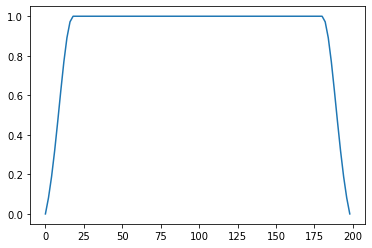

In [188]:
times = np.linspace(0, N*dt, 100)
vals = pulse_func(times)
plt.plot(times, vals)

In [12]:
# first simulate full Hamiltonian to as high a precision as possible for comparisons
ham = HamiltonianModel(operators=[H0_B, Hdc_B])

As a function

In [13]:
def full_sim(taur, sig):
    ham_copy = ham.copy()
    drive_func = lambda t: pulse(sig, taur, tau, t)
    ham_copy.signals = [1., Signal(drive_func, carrier_freq=v_d)]
    ham_copy.frame = ham_copy.drift
    
    results = solve_lmde(ham_copy, 
                     t_span=[0, N*dt],
                     y0=jnp.eye(dim**2, dtype=complex),
                     method='jax_odeint',
                     atol=1e-15,
                     rtol=1e-15)

    return results.y[-1]

# just in time compile it
jit_sim = jit(full_sim)

## 2.1 measure single jit + simulate

In [14]:
start = time()
single_sim_y = jit_sim(taur/5, sig).block_until_ready()
print(time() - start)

12.19560980796814


In [15]:
start = time()
single_sim_y = jit_sim(taur/5, sig).block_until_ready()
print(time() - start)

10.631766080856323


In [16]:
tau_vals = taur * jnp.linspace(0.1, 5, 20)

## 2.2 measure vmap jit + simulate

In [17]:
jit_vmap_sim = jit(vmap(lambda tau: full_sim(tau, sig)))

In [18]:
start = time()
direct_sim_y = jit_vmap_sim(tau_vals).block_until_ready()
sim_time = time() - start
print('Batch simulation time including jit: ' + str(sim_time))
print('Batch simulation average time including jit: ' + str(sim_time / len(tau_vals)))

Batch simulation time including jit: 299.34338903427124
Batch simulation average time including jit: 14.967169451713563


In [19]:
start = time()
direct_sim_y = jit_vmap_sim(tau_vals).block_until_ready()
sim_time = time() - start
print('Batch simulation time without jit: ' + str(sim_time))
print('Batch simulation average time without jit: ' + str(sim_time / len(tau_vals)))

Batch simulation time without jit: 302.1729688644409
Batch simulation average time without jit: 15.108648443222046


## 2.3 Simulate at lower tolerance

Here we set the tolerance of the simulation to try to achieve about $10^{-5}$ infidelity.

In [20]:
def full_sim2(taur, sig):
    ham_copy = ham.copy()
    drive_func = lambda t: pulse(sig, taur, tau, t)
    ham_copy.signals = [1., Signal(drive_func, carrier_freq=v_d)]
    ham_copy.frame = ham_copy.drift
    
    results = solve_lmde(ham_copy, 
                     t_span=[0, N*dt],
                     y0=jnp.eye(dim**2, dtype=complex),
                     method='jax_odeint',
                    atol=2.5*1e-8,
                    rtol=2.5*1e-8)

    return results.y[-1]

jit_sim2 = jit(full_sim2)

### 2.3.1 Measure single jit + sim time 

In [21]:
start = time()
single_sim_lower_tol_y = jit_sim2(taur/5, sig).block_until_ready()
print(time() - start)

1.9738318920135498


In [22]:
start = time()
single_sim_lower_tol_y = jit_sim2(taur/5, sig).block_until_ready()
print(time() - start)

0.3734090328216553


In [23]:
1-(jnp.abs((single_sim_lower_tol_y.conj().transpose() @ single_sim_y).trace()) / (dim**2))**2

DeviceArray(-1.80845397e-05, dtype=float64)

### 2.3.2 Measure vmap jit + sim time

In [24]:
jit_vmap_sim_lower_tol = jit(vmap(lambda tau: full_sim2(tau, sig)))

In [25]:
start = time()
direct_sim_lower_tol_y = jit_vmap_sim_lower_tol(tau_vals).block_until_ready()
sim_time = time() - start
print('Batch simulation time including jit: ' + str(sim_time))
print('Batch simulation average time including jit: ' + str(sim_time / len(tau_vals)))

Batch simulation time including jit: 13.062049150466919
Batch simulation average time including jit: 0.653102457523346


In [26]:
start = time()
direct_sim_lower_tol_y = jit_vmap_sim_lower_tol(tau_vals).block_until_ready()
sim_time = time() - start
print('Batch simulation time without jit: ' + str(sim_time))
print('Batch simulation average time without jit: ' + str(sim_time / len(tau_vals)))

Batch simulation time without jit: 10.379701852798462
Batch simulation average time without jit: 0.5189850926399231


In [27]:
infidelities = []
for k in range(len(tau_vals)):
    infidelities.append(1-(jnp.abs((direct_sim_lower_tol_y[k].conj().transpose() @ direct_sim_y[k]).trace()) / (dim**2))**2)

In [28]:
infidelities

[DeviceArray(-1.93513923e-05, dtype=float64),
 DeviceArray(-2.13321402e-05, dtype=float64),
 DeviceArray(-1.91729934e-05, dtype=float64),
 DeviceArray(-2.3012992e-05, dtype=float64),
 DeviceArray(-2.46294768e-05, dtype=float64),
 DeviceArray(-2.22496564e-05, dtype=float64),
 DeviceArray(-2.37075782e-05, dtype=float64),
 DeviceArray(-1.58428055e-05, dtype=float64),
 DeviceArray(-2.28007174e-05, dtype=float64),
 DeviceArray(-2.13084367e-05, dtype=float64),
 DeviceArray(-1.14161642e-05, dtype=float64),
 DeviceArray(-1.87988642e-05, dtype=float64),
 DeviceArray(-9.84193965e-06, dtype=float64),
 DeviceArray(-9.54430523e-06, dtype=float64),
 DeviceArray(-8.27206379e-06, dtype=float64),
 DeviceArray(-9.70355804e-06, dtype=float64),
 DeviceArray(-7.78974991e-06, dtype=float64),
 DeviceArray(-6.29514242e-06, dtype=float64),
 DeviceArray(-7.91626331e-06, dtype=float64),
 DeviceArray(-5.66326902e-06, dtype=float64)]

# 3. RWA simulation

In [189]:
def rwa_sim(taur, sig):
    ham_copy = ham.copy()
    drive_func = lambda t: pulse(sig, taur, tau, t)
    ham_copy.signals = [1., Signal(drive_func, carrier_freq=v_d)]
    ham_copy.frame = ham_copy.drift
    ham_copy.cutoff_freq = 1.9 * v_d # add cutoff
    
    results = solve_lmde(ham_copy, 
                     t_span=[0, N*dt],
                     y0=jnp.eye(dim**2, dtype=complex),
                     method='jax_odeint',
                    atol=1e-6,
                    rtol=1e-6)

    return results.y[-1]

# just in time compile it
jit_rwa_sim = jit(rwa_sim)

In [190]:
start = time()
single_rwa_sim_y = jit_rwa_sim(taur/5, sig).block_until_ready()
print(time() - start)

2.210222005844116


In [191]:
start = time()
single_rwa_sim_y = jit_rwa_sim(taur/5, sig).block_until_ready()
print(time() - start)

0.1817007064819336


In [192]:
1-(jnp.abs((single_rwa_sim_y.conj().transpose() @ single_sim_y).trace()) / (dim**2))**2

DeviceArray(0.00629096, dtype=float64)

### 3.1 Measure vmap jit + sim time

In [193]:
jit_vmap_rwa_sim = jit(vmap(lambda tau: rwa_sim(tau, sig)))

In [194]:
start = time()
rwa_sim_y = jit_vmap_rwa_sim(tau_vals).block_until_ready()
sim_time = time() - start
print('Batch simulation time including jit: ' + str(sim_time))
print('Batch simulation average time including jit: ' + str(sim_time / len(tau_vals)))

Batch simulation time including jit: 8.29793095588684
Batch simulation average time including jit: 0.41489654779434204


In [195]:
start = time()
rwa_sim_y = jit_vmap_rwa_sim(tau_vals).block_until_ready()
sim_time = time() - start
print('Batch simulation time without jit: ' + str(sim_time))
print('Batch simulation average time without jit: ' + str(sim_time / len(tau_vals)))

Batch simulation time without jit: 4.756246089935303
Batch simulation average time without jit: 0.23781230449676513


In [196]:
infidelities = []
for k in range(len(tau_vals)):
    infidelities.append(1-(jnp.abs((rwa_sim_y[k].conj().transpose() @ direct_sim_y[k]).trace()) / (dim**2))**2)

In [197]:
infidelities

[DeviceArray(0.0059107, dtype=float64),
 DeviceArray(0.0057578, dtype=float64),
 DeviceArray(0.00604149, dtype=float64),
 DeviceArray(0.00565438, dtype=float64),
 DeviceArray(0.00460941, dtype=float64),
 DeviceArray(0.00383892, dtype=float64),
 DeviceArray(0.00379682, dtype=float64),
 DeviceArray(0.00301357, dtype=float64),
 DeviceArray(0.00286364, dtype=float64),
 DeviceArray(0.00173735, dtype=float64),
 DeviceArray(0.00157314, dtype=float64),
 DeviceArray(0.00158676, dtype=float64),
 DeviceArray(0.0009665, dtype=float64),
 DeviceArray(0.00093395, dtype=float64),
 DeviceArray(0.00066457, dtype=float64),
 DeviceArray(0.0003809, dtype=float64),
 DeviceArray(-3.07893977e-05, dtype=float64),
 DeviceArray(-0.00013692, dtype=float64),
 DeviceArray(-5.75767116e-05, dtype=float64),
 DeviceArray(-0.00015253, dtype=float64)]

In the above we see the speed benefits of the RWA, however the fidelity of the simulation is fundamentally limited by the approximation.

# 4. Magnus based approximate simulation

Next, we simulate the system using the Magnus-RWA method. For this approach, over each short interval, we approximate the drive envelope as a polynomial decomposed via Chebyshev polynomials. For a fixed time interval, we compute Magnus terms for these Chebyshev polynomial drive terms (up to some order).

Given these pre-computed Magnus terms, to simulate:
- For each time interval, compute Chebyshev coefficients for drive envelope
- Take linear combination of Magnus terms based on these coefficients and exponentiate
- Multiply by frame correction

First, we set up the chebyshev approximation routine.

In [104]:
def get_DCT_data(deg, domain=[-1, 1]):
    """Construct DCT matrix for a given degree, and 
    compute the shifted chebyshev points for computing the approximation over
    domain
    """
    order = deg + 1
    xcheb = chebpts1(order)
    xcheb_shifted = 0.5*((domain[1] - domain[0]) * xcheb + (domain[1] + domain[0]))
    
    dct_mat = chebvander(xcheb, deg).T
    dct_mat[0] /= order
    dct_mat[1:] /= 0.5 * order
    
    return dct_mat, xcheb_shifted

def perform_DCT(func, dct_mat, xcheb_shifted):
    # assume vectorized
    func_vals = func(xcheb_shifted)
    return np.dot(dct_mat, func_vals)

def multi_interval_DCT(func, dct_mat, xcheb_shifted, start_point_shifts):
    dct_coeffs = [perform_DCT(func, dct_mat, xcheb_shifted + point) for point in start_point_shifts]
    return np.array(dct_coeffs)

def construct_multi_interval_DCT(deg, dt, n_intervals, start_time):
    
    # construct chebyshev data for a single interval
    dct_mat, xcheb_0 = get_DCT_data(deg, domain=[0, dt])
    
    # compute all times at which the function needs to be evaluated
    interval_start_times = start_time + np.arange(n_intervals) * dt
    # time values: columns correspond to interval, rows are the shifted chebyshev values
    t_vals = np.add.outer(xcheb_0, interval_start_times)
    
    def approx_func(func):
        f_vals = func(t_vals)
        
        return dct_mat @ f_vals

    return approx_func

In [105]:
approx_func = construct_multi_interval_DCT(2, dt, N, start_time=0)

In [106]:
vec_pulse_func = jnp.vectorize(pulse_func)

In [107]:
cheb_coeffs = approx_func(vec_pulse_func)

## Chebyshev evaluation

Function for evaluating Chebyshev 

In [108]:
def evaluate_cheb_series(x, c, domain=[-1, 1]):
    """Evaluate a chebyshev series on a given domain.
    Aside from the domain modification this is copied from numpy,
    though I think this is a pretty classic algorithm
    """
    x = (2 * x - domain[1] - domain[0]) / (domain[1] - domain[0])

    if len(c) == 1:
        c0 = c[0]
        c1 = 0
    elif len(c) == 2:
        c0 = c[0]
        c1 = c[1]
    else:
        x2 = 2*x
        
        def scan_fun(carry, idx):
            c0, c1 = carry
            tmp = c0
            c0 = c[-idx] - c1
            c1 = tmp + c1 * x2
            return (c0, c1), None
        
        c0, c1 = scan(scan_fun, init=(c[-2], c[-1]), xs=jnp.arange(3, len(c) + 1))[0]
        
    return c0 + c1*x

def approx_func_as_callable(cheb_coeffs, dt, n_intervals, start_time):
    interval_start_times = start_time + np.arange(n_intervals) * dt
    
    def approx_func(t):
        k = jnp.clip(jnp.array(t // dt, dtype=int), 0, cheb_coeffs.shape[-1]-1)
        return evaluate_cheb_series(t - (k * dt), cheb_coeffs[:, k], [0, dt])
    return approx_func
    

In [109]:
approx_pulse_func = approx_func_as_callable(cheb_coeffs, dt, N, 0)

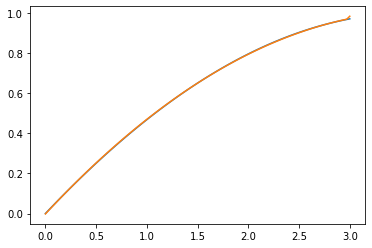

In [111]:
k = 0
times = np.linspace(k*dt, (k+1)*dt, 100)
vals = vec_pulse_func(times)
approx_vals = approx_pulse_func(times)
plt.plot(times, vals, times, approx_vals)
# difference on a log scale!!

## Compute magnus approx with chebyshev polynomials

In [44]:
def G(t):
    return -1j * H0_B

def T0(t, t0):
    return evaluate_cheb_series(t - t0, [1], domain=[0, dt])

def A0(t, t0):
    return -1j * T0(t, t0) * jnp.cos(w_d * t) * Hdc_B

def T1(t, t0):
    return evaluate_cheb_series(t - t0, [0, 1], domain=[0, dt])

def A1(t, t0):
    return -1j * T1(t, t0) * jnp.cos(w_d * t) * Hdc_B

def T2(t, t0):
    return evaluate_cheb_series(t - t0, jnp.array([0, 0, 1], dtype=float), domain=[0, dt])

def A2(t, t0):
    return -1j * T2(t, t0) * jnp.cos(w_d * t) * Hdc_B

In [163]:
start = time()
mag_results = solve_lmde_perturbation(A_list=[lambda t: A0(t, 0), lambda t: A1(t, 0), lambda t: A2(t, 0)],
                                  perturbation_method='symmetric_magnus',
                                  perturbation_order=5,
                                  perturbation_terms=[[0, 0, 0, 0, 0, 0, 0]],
                                  t_span=[0, dt],
                                  generator=G,
                                  method='jax_odeint',
                                  atol=1e-8,
                                  rtol=1e-8)
print(time() - start)

12.65750503540039


## Approx simulation

In [164]:
# For perfect solutions the Magnus terms are guaranteed to be anti-hermitian,
# but anti-hermiticity doesn't need to be respected in the initial solver tolerance
# So, when extracting, project onto the real subspace of anti-hermitian operators
def to_aherm(A):
    return 0.5 * (A - A.conj().transpose())

M0 = to_aherm(mag_results.perturbation_results[[0]][-1])
M1 = to_aherm(mag_results.perturbation_results[[1]][-1])
M2 = to_aherm(mag_results.perturbation_results[[2]][-1])
M00 = to_aherm(mag_results.perturbation_results[[0, 0]][-1])
M01 = to_aherm(mag_results.perturbation_results[[0, 1]][-1])
M02 = to_aherm(mag_results.perturbation_results[[0, 2]][-1])
M11 = to_aherm(mag_results.perturbation_results[[1, 1]][-1])
M12 = to_aherm(mag_results.perturbation_results[[1, 2]][-1])
M22 = to_aherm(mag_results.perturbation_results[[2, 2]][-1])
M000 = to_aherm(mag_results.perturbation_results[[0, 0, 0]][-1])
M001 = to_aherm(mag_results.perturbation_results[[0, 0, 1]][-1])
M002 = to_aherm(mag_results.perturbation_results[[0, 0, 2]][-1])
M011 = to_aherm(mag_results.perturbation_results[[0, 1, 1]][-1])
M012 = to_aherm(mag_results.perturbation_results[[0, 1, 2]][-1])
M022 = to_aherm(mag_results.perturbation_results[[0, 2, 2]][-1])
M111 = to_aherm(mag_results.perturbation_results[[1, 1, 1]][-1])
M112 = to_aherm(mag_results.perturbation_results[[1, 1, 2]][-1])
M122 = to_aherm(mag_results.perturbation_results[[1, 2, 2]][-1])
M222 = to_aherm(mag_results.perturbation_results[[2, 2, 2]][-1])
M0000 = to_aherm(mag_results.perturbation_results[[0, 0, 0, 0]][-1])
M0001 = to_aherm(mag_results.perturbation_results[[0, 0, 0, 1]][-1])
M0002 = to_aherm(mag_results.perturbation_results[[0, 0, 0, 2]][-1])
M0011 = to_aherm(mag_results.perturbation_results[[0, 0, 1, 1]][-1])
M0012 = to_aherm(mag_results.perturbation_results[[0, 0, 1, 2]][-1])
M0022 = to_aherm(mag_results.perturbation_results[[0, 0, 2, 2]][-1])
M0111 = to_aherm(mag_results.perturbation_results[[0, 1, 1, 1]][-1])
M0112 = to_aherm(mag_results.perturbation_results[[0, 1, 1, 2]][-1])
M0122 = to_aherm(mag_results.perturbation_results[[0, 1, 2, 2]][-1])
M0222 = to_aherm(mag_results.perturbation_results[[0, 2, 2, 2]][-1])
M1111 = to_aherm(mag_results.perturbation_results[[1, 1, 1, 1]][-1])
M1112 = to_aherm(mag_results.perturbation_results[[1, 1, 1, 2]][-1])
M1122 = to_aherm(mag_results.perturbation_results[[1, 1, 2, 2]][-1])
M1222 = to_aherm(mag_results.perturbation_results[[1, 2, 2, 2]][-1])
M2222 = to_aherm(mag_results.perturbation_results[[2, 2, 2, 2]][-1])
M00000 = to_aherm(mag_results.perturbation_results[[0, 0, 0, 0, 0]][-1])
M00001 = to_aherm(mag_results.perturbation_results[[0, 0, 0, 0, 1]][-1])
M00002 = to_aherm(mag_results.perturbation_results[[0, 0, 0, 0, 2]][-1])
M00011 = to_aherm(mag_results.perturbation_results[[0, 0, 0, 1, 1]][-1])
M00012 = to_aherm(mag_results.perturbation_results[[0, 0, 0, 1, 2]][-1])
M00022 = to_aherm(mag_results.perturbation_results[[0, 0, 0, 2, 2]][-1])
M00111 = to_aherm(mag_results.perturbation_results[[0, 0, 1, 1, 1]][-1])
M00112 = to_aherm(mag_results.perturbation_results[[0, 0, 1, 1, 2]][-1])
M00122 = to_aherm(mag_results.perturbation_results[[0, 0, 1, 2, 2]][-1])
M00222 = to_aherm(mag_results.perturbation_results[[0, 0, 2, 2, 2]][-1])
M01111 = to_aherm(mag_results.perturbation_results[[0, 1, 1, 1, 1]][-1])
M01112 = to_aherm(mag_results.perturbation_results[[0, 1, 1, 1, 2]][-1])
M01122 = to_aherm(mag_results.perturbation_results[[0, 1, 1, 2, 2]][-1])
M01222 = to_aherm(mag_results.perturbation_results[[0, 1, 2, 2, 2]][-1])
M02222 = to_aherm(mag_results.perturbation_results[[0, 2, 2, 2, 2]][-1])
M11111 = to_aherm(mag_results.perturbation_results[[1, 1, 1, 1, 1]][-1])
M11112 = to_aherm(mag_results.perturbation_results[[1, 1, 1, 1, 2]][-1])
M11122 = to_aherm(mag_results.perturbation_results[[1, 1, 1, 2, 2]][-1])
M11222 = to_aherm(mag_results.perturbation_results[[1, 1, 2, 2, 2]][-1])
M12222 = to_aherm(mag_results.perturbation_results[[1, 2, 2, 2, 2]][-1])
M22222 = to_aherm(mag_results.perturbation_results[[2, 2, 2, 2, 2]][-1])
M000000 = to_aherm(mag_results.perturbation_results[[0, 0, 0, 0, 0, 0]][-1])
M0000000 = to_aherm(mag_results.perturbation_results[[0, 0, 0, 0, 0, 0, 0]][-1])

# single step frame operator
Uf_dt = jexpm(-1j * H0_B * dt)

# final step frame operator
Uf = jexpm(1j * H0_B * N * dt)

In [165]:
def magnus_sim(taur, sig):
    drive_func = jnp.vectorize(lambda t: pulse(sig, taur, tau, t))
    c_coeffs = approx_func(drive_func)
    
    def approx_gen(k):
        coeffs = c_coeffs[:, k]
        c0 = coeffs[0]
        c1 = coeffs[1]
        c2 = coeffs[2]
        c00 = c0 * c0
        c01 = c0 * c1
        c02 = c0 * c2
        c11 = c1 * c1
        c12 = c1 * c2
        c22 = c2 * c2
        c000 = c0 * c00
        c001 = c0 * c01
        c002 = c0 * c02
        c011 = c0 * c11
        c012 = c0 * c12
        c022 = c0 * c22
        c111 = c1 * c11
        c112 = c1 * c12
        c122 = c1 * c22
        c222 = c2 * c22
        c0000 = c0 * c000
        c0001 = c0 * c001
        c0002 = c0 * c002
        c0011 = c0 * c011
        c0012 = c0 * c012
        c0022 = c0 * c022
        c0111 = c0 * c111
        c0112 = c0 * c112
        c0122 = c0 * c122
        c0222 = c0 * c222
        c1111 = c1 * c111
        c1112 = c1 * c112
        c1122 = c1 * c122
        c1222 = c1 * c222
        c2222 = c2 * c222
        c00000 = c0 * c0000
        c00001 = c0 * c0001
        c00002 = c0 * c0002
        c00011 = c0 * c0011
        c00012 = c0 * c0012
        c00022 = c0 * c0022
        c00111 = c0 * c0111
        c00112 = c0 * c0112
        c00122 = c0 * c0122
        c00222 = c0 * c0222
        c01111 = c0 * c1111
        c01112 = c0 * c1112
        c01122 = c0 * c1122
        c01222 = c0 * c1222
        c02222 = c0 * c2222
        c11111 = c1 * c1111
        c11112 = c1 * c1112
        c11122 = c1 * c1122
        c11222 = c1 * c1222
        c12222 = c1 * c2222
        c22222 = c2 * c2222
        c000000 = c0 * c00000
        c0000000 = c0 * c000000
    
        return (c0 * M0
                + c1 * M1
                + c2 * M2
                + c00 * M00
                + c01 * M01
                + c02 * M02
                + c11 * M11
                + c12 * M12
                + c22 * M22
                + c000 * M000
                + c001 * M001
                + c002 * M002
                + c011 * M011
                + c012 * M012
                + c022 * M022
                + c111 * M111
                + c112 * M112
                + c122 * M112
                + c222 * M222
                + c0000 * M0000
                + c0001 * M0001
                + c0002 * M0002
                + c0011 * M0011
                + c0012 * M0012
                + c0022 * M0022
                + c0111 * M0111
                + c0112 * M0112
                + c0122 * M0122
                + c0222 * M0222
                + c1111 * M1111
                + c1112 * M1112
                + c1122 * M1122
                + c1222 * M1222
                + c2222 * M2222
                + c00001 * M00001
                + c00002 * M00002
                + c00011 * M00011
                + c00012 * M00012
                + c00022 * M00022
                + c00111 * M00111
                + c00112 * M00112
                + c00122 * M00122
                + c00222 * M00222
                + c01111 * M01111
                + c01112 * M01112
                + c01122 * M01122
                + c01222 * M01222
                + c02222 * M02222
                + c11111 * M11111
                + c11112 * M11112
                + c11122 * M11122
                + c11222 * M11222
                + c12222 * M12222
                + c22222 * M22222
                + c000000 * M000000
                + c0000000 * M0000000)


    def single_step(k):
        return Uf_dt @ jexpm(approx_gen(k))
    
    step_propagators = vmap(single_step)(jnp.flip(jnp.arange(0, N, dtype=int)))
    final_prop = associative_scan(jnp.matmul, step_propagators, axis=0)[-1]
    
    return Uf @ final_prop
    
    
    
jit_magnus_sim = jit(magnus_sim)

In [166]:
start = time()
single_magnus_y = jit_magnus_sim(taur/5, sig).block_until_ready()
print(time() - start)

5.5539000034332275


In [167]:
start = time()
single_magnus_y = jit_magnus_sim(taur/5, sig).block_until_ready()
print(time() - start)

0.008199214935302734


In [168]:
1-(jnp.abs((single_magnus_y.conj().transpose() @ single_sim_y).trace()) / (dim**2))**2

DeviceArray(4.16113777e-06, dtype=float64)

### 4.1 Measure vmap jit + sim time

In [169]:
jit_vmap_magnus_sim = jit(vmap(lambda tau: magnus_sim(tau, sig)))

In [170]:
start = time()
vmap_magnus_sim_y = jit_vmap_magnus_sim(tau_vals).block_until_ready()
sim_time = time() - start
print('Batch simulation time including jit: ' + str(sim_time))
print('Batch simulation average time including jit: ' + str(sim_time / len(tau_vals)))

Batch simulation time including jit: 8.566042184829712
Batch simulation average time including jit: 0.4283021092414856


In [171]:
start = time()
vmap_magnus_sim_y = jit_vmap_magnus_sim(tau_vals).block_until_ready()
sim_time = time() - start
print('Batch simulation time without jit: ' + str(sim_time))
print('Batch simulation average time without jit: ' + str(sim_time / len(tau_vals)))

Batch simulation time without jit: 0.16030621528625488
Batch simulation average time without jit: 0.008015310764312744


In [172]:
infidelities = []
for k in range(len(tau_vals)):
    infidelities.append(1-(jnp.abs((vmap_magnus_sim_y[k].conj().transpose() @ direct_sim_y[k]).trace()) / (dim**2))**2)

In [173]:
infidelities

[DeviceArray(0.00058087, dtype=float64),
 DeviceArray(1.04527318e-06, dtype=float64),
 DeviceArray(9.09271775e-07, dtype=float64),
 DeviceArray(6.3152949e-07, dtype=float64),
 DeviceArray(6.47115417e-07, dtype=float64),
 DeviceArray(7.09606204e-07, dtype=float64),
 DeviceArray(5.07156616e-07, dtype=float64),
 DeviceArray(7.29249733e-07, dtype=float64),
 DeviceArray(4.13983232e-07, dtype=float64),
 DeviceArray(4.71617567e-07, dtype=float64),
 DeviceArray(3.25865063e-07, dtype=float64),
 DeviceArray(4.58666453e-07, dtype=float64),
 DeviceArray(2.44367552e-07, dtype=float64),
 DeviceArray(3.07571517e-07, dtype=float64),
 DeviceArray(2.18062584e-07, dtype=float64),
 DeviceArray(1.46536393e-07, dtype=float64),
 DeviceArray(2.24755255e-07, dtype=float64),
 DeviceArray(6.7781357e-08, dtype=float64),
 DeviceArray(3.54294667e-07, dtype=float64),
 DeviceArray(2.95954485e-08, dtype=float64)]

In [174]:
dist_to_id = []
for k in range(len(vmap_magnus_sim_y)):
    dist_to_id.append(jnp.linalg.norm(vmap_magnus_sim_y[k].conj().transpose() @ vmap_magnus_sim_y[k] - jnp.eye(dim**2, dtype=complex)))

In [175]:
print(dist_to_id)

[DeviceArray(3.03469738e-12, dtype=float64), DeviceArray(3.02274631e-12, dtype=float64), DeviceArray(3.01700341e-12, dtype=float64), DeviceArray(3.01956091e-12, dtype=float64), DeviceArray(3.02472066e-12, dtype=float64), DeviceArray(3.02886782e-12, dtype=float64), DeviceArray(3.0361814e-12, dtype=float64), DeviceArray(3.0396323e-12, dtype=float64), DeviceArray(3.05001266e-12, dtype=float64), DeviceArray(3.05370166e-12, dtype=float64), DeviceArray(3.06248321e-12, dtype=float64), DeviceArray(3.06954267e-12, dtype=float64), DeviceArray(3.07395517e-12, dtype=float64), DeviceArray(3.08143205e-12, dtype=float64), DeviceArray(3.08790244e-12, dtype=float64), DeviceArray(3.09343709e-12, dtype=float64), DeviceArray(3.10418244e-12, dtype=float64), DeviceArray(3.11226923e-12, dtype=float64), DeviceArray(3.11813169e-12, dtype=float64), DeviceArray(3.12011715e-12, dtype=float64)]


In [162]:
jnp.linalg.norm(M0 + M0.conj().transpose())

DeviceArray(7.32059201e-07, dtype=float64)